# Optimizing a Logistic Regression 🚀🚀🚀

Let's create a credit scoring Model using the German Credit scoring dataset [(Link](https://github.com/Giskard-AI/giskard-client/tree/main/sample_data/classification) to download the dataset)

In [397]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import model_selection
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, \
    RocCurveDisplay, accuracy_score
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, SMOTENC


In [398]:
# To download and read the credit scoring dataset
url = 'https://raw.githubusercontent.com/Giskard-AI/examples/main/datasets/credit_scoring_classification_model_dataset/german_credit_prepared.csv'
credit = pd.read_csv(url, sep=',',engine="python") #To download go to https://github.com/Giskard-AI/giskard-client/tree/main/sample_data/classification

In [399]:
# Declare the type of each column in the dataset(example: category, numeric, text)
column_types = {'default':"category",
               'account_check_status':"category", 
               'duration_in_month':"numeric",
               'credit_history':"category",
               'purpose':"category",
               'credit_amount':"numeric",
               'savings':"category",
               'present_employment_since':"category",
               'installment_as_income_perc':"numeric",
               'sex':"category",
               'personal_status':"category",
               'other_debtors':"category",
               'present_residence_since':"numeric",
               'property':"category",
               'age':"numeric",
               'other_installment_plans':"category",
               'housing':"category",
               'credits_this_bank':"numeric",
               'job':"category",
               'people_under_maintenance':"numeric",
               'telephone':"category",
               'foreign_worker':"category"}

In [400]:
# feature_types is used to declare the features the model is trained on
feature_types = {i: column_types[i] for i in column_types if i != 'default'}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys()
                    if feature_types[key] == "numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [
    key for key in feature_types.keys() if feature_types[key] == "category"]
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_to_scale),
        ('cat', categorical_transformer, columns_to_encode)
    ]
)

# Pipeline for the model Logistic Regression
clf_logistic_regression = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', LogisticRegression(max_iter=1000))])

dummy_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', DummyClassifier())])

# Split the data into train and test
y = credit['default']
X = credit.drop(columns='default')
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.20, random_state=30, stratify=y)

In [9]:
clf_logistic_regression.fit(X_train, y_train)
dummy_pipeline.fit(X_train, y_train)

y_pred_test_log = clf_logistic_regression.predict(X_test)
y_pred_test_dum = dummy_pipeline.predict(X_test)

print(f"Dummy's classifier accuracy is : \
{format(accuracy_score(y_test, y_pred_test_dum))}\
\nLogisticRegression's accuracy is : \
{format(accuracy_score(y_test, y_pred_test_log))}")

Dummy's classifier accuracy is : 0.7
LogisticRegression's accuracy is : 0.755


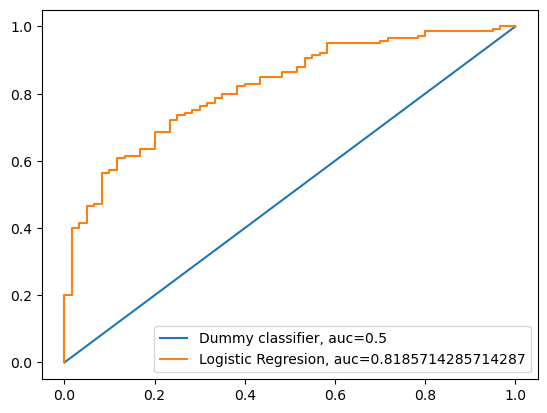

In [10]:
y_proba_log = clf_logistic_regression.predict_proba(X_test)[:, 1]
y_proba_dum = dummy_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba_dum, pos_label='Not default')
auc = roc_auc_score(y_test, y_proba_dum)
plt.plot(fpr, tpr, label="Dummy classifier, auc="+str(auc, ))

fpr, tpr, _ = roc_curve(y_test, y_proba_log, pos_label='Not default')
auc = roc_auc_score(y_test, y_proba_log)
plt.plot(fpr, tpr, label="Logistic Regresion, auc="+str(auc))

plt.legend()


In [11]:
# Prepare data to upload on Giskard
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test ], axis=1)

# Happy Exploration ! 🧑‍🚀

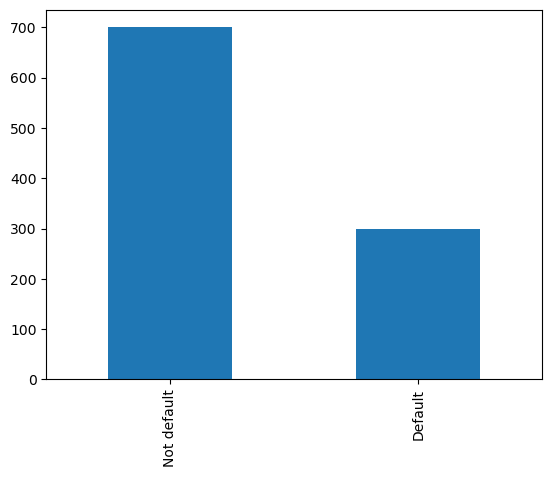

In [24]:
credit.default.value_counts().plot(kind='bar')
plt.show()

The dataset is quite imbalanced. We will try to strengthen it by 2 different methods. In fact, we know that Imbalanced Dataset is a huge difficulty for training ML models in general.
## Oversampling with SMOTENC
SMOTENC can handle datasets with both categorical and continuous features by interpolating the continuous features and using a nearest-neighbor approach to handle the categorical features. It improves the performance of classification models on imbalanced datasets by generating synthetic samples that can help balance the class distribution.

<AxesSubplot:>

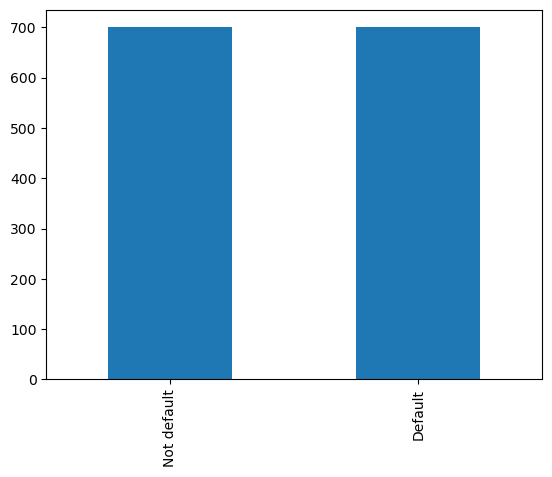

In [401]:
y = credit['default']
X = credit.drop(columns='default')

indices = X.columns.get_indexer(columns_to_encode)
oversample = SMOTENC(categorical_features=indices)
X_over, y_over = oversample.fit_resample(X, y)
y_over.value_counts().plot(kind='bar')

In [402]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_over, y_over, test_size=0.20, random_state=30, stratify=y_over)

clf_logistic_regression.fit(X_train, y_train)
y_pred_test_over = clf_logistic_regression.predict(X_test)

print(f"Logistic Regression accuracy is : \
{format(accuracy_score(y_test, y_pred_test_over))}")


Logistic Regression accuracy is : 0.7714285714285715


We have improved from 0.755 to 0.77. Tiny improvement for this method.

## Variational autoencoder for Tabular Data

We will use VAE to generate new data, in order for the dataset to be less imbalanced. In this purpose, we are going to train our VAE with the minority classe 'Default' for it to understand how the minority class is built. We will then have new 'Default' data. We will use them by concatenating it to X_train for the training of the Logistic Regression.  
The VAE consists of a concatenation of 2 CNN, one encoder and one decoder. The encoder maps the data into a lower-dimension latent space and the decoder is able to reproduce new data from the latent space to the original data space. We will therefore create some random samples in the latent space
The VAE consists of an encoder network that maps the input data to a lower-dimensional latent space, and a decoder network that maps the latent space back to the original data space. The encoder network is trained to learn a probability distribution over the latent space, and the decoder network is trained to generate new data samples from this distribution. By sampling new data points from the learned latent space distribution, the VAE can generate synthetic data that has similar properties to the original imbalanced dataset, which can be used to balance the dataset.  

In [405]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras import layers


In [406]:
# feature_types is used to declare the features the model is trained on
feature_types = {i: column_types[i] for i in column_types}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys()
                    if feature_types[key] == "numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [
    key for key in feature_types.keys() if feature_types[key] == "category"]

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_to_scale),
        ('cat', categorical_transformer, columns_to_encode)
    ]
)

df = preprocessor.fit_transform(credit.loc[credit.default=='Default'])
dfarray = df.reshape(-1, df.shape[1], 1, 1)

img_size_1 = dfarray.shape[1]
latent_space_dim = 2
img_size_1

63

In [407]:
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size_1, 1, 1), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

#encoder.summary()

In [408]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=2016, name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=(63,1,32))(decoder_dense_layer1)

decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(2, 2), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )
decode = tensorflow.keras.layers.Reshape(target_shape=(63, 1, 1))
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
 
#decoder.summary()

In [409]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [410]:
vae_input = tensorflow.keras.layers.Input(shape=(img_size_1, 1, 1), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
# vae.summary()

In [411]:
vae.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

In [245]:
[print(i.shape, i.dtype) for i in vae.inputs]
[print(o.shape, o.dtype) for o in vae.outputs]
[print(l.name, l.input_shape, l.dtype) for l in vae.layers]

(None, 63, 1, 1) <dtype: 'float32'>
(None, 63, 1, 1) <dtype: 'float32'>
VAE_input [(None, 63, 1, 1)] float32
encoder_model (None, 63, 1, 1) float32
decoder_model (None, 2) float32


[None, None, None]

In [432]:
vae.fit(dfarray, dfarray, epochs=1000, batch_size=63, shuffle=True, verbose=False)

In [436]:
z_sample = np.array([[-1, 0.6]])
example_predicted = decoder.predict(encoder.predict(dfarray[5:10]))

def replace_categ_values(predicted):
    threshold = 0.6
    for i in np.arange(7, predicted.shape[1]):
        for j in np.arange(predicted.shape[0]):
            # predicted[j, i, 0, 0] = np.where(predicted[j, i, 0, 0] > 0.6, 1, 0)
            if predicted[j, i] >= threshold:
                predicted[j, i] = 1
            else:
                predicted[j, i] = 0
                
        
                     
    return predicted[:, :]

pd.DataFrame(replace_categ_values(example_predicted.reshape(-1, 63)))

1/1 [==============================] - 0s 44ms/step


,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,-0.451024,-0.442523,0.830953,1.079458,2.406741,1.036515,-0.522866,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.275837,-0.556720,0.153074,-0.393873,-0.363100,-0.623400,-0.346270,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,-0.191560,2.441650,0.791025,0.214106,0.767995,-0.736589,-0.546071,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.786218,0.887537,0.320896,1.459353,1.788432,0.908437,-0.543300,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.350258,-0.239330,0.690964,-0.521554,-0.200515,1.348614,-0.451622,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We can see above that we got back the full Default column at the 7th index with only ones.

In [434]:
scale = 1.0
n = 20
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

synthetic_data = []
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        synthetic_data.append(x_decoded[0])


1/1 [==============================] - 0s 20ms/step


In [437]:
syn_data = np.array(synthetic_data).reshape(-1, 63)
syn_data = replace_categ_values(syn_data)
X = preprocessor.fit_transform(credit)
pd.DataFrame(syn_data)

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,-0.154103,-0.424400,1.273410,1.141874,-0.239079,2.861589,-0.561431,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.191070,-0.408251,1.104630,1.186509,-0.324629,3.099981,-0.595744,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.228790,-0.382263,0.904058,1.213672,-0.386094,3.323000,-0.633332,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.262156,-0.354555,0.661435,1.259432,-0.438118,3.544731,-0.672607,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.290411,-0.343755,0.467818,1.276183,-0.488722,3.735743,-0.702198,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.519783,-0.181439,-0.414375,1.121490,1.311907,2.255197,0.238076,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
396,-0.530452,-0.267475,-0.275554,1.008689,1.279908,2.024763,0.580011,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
397,-0.536913,-0.344651,-0.138956,0.851754,1.265307,1.774167,0.940160,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
398,-0.541613,-0.426260,-0.006859,0.682387,1.246855,1.512272,1.306500,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


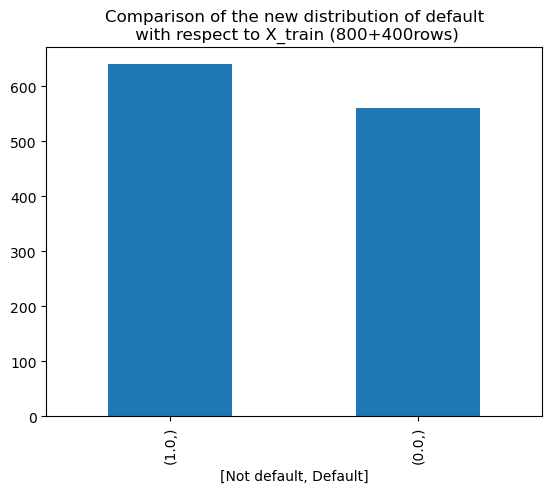

In [438]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.20, random_state=30, stratify=y)

X_improved = np.concatenate((np.delete(X_train, 44, axis=1), syn_data), axis=0)

pd.DataFrame(X_improved[:, 7]).value_counts().plot(kind='bar', 
                                                   xlabel = ['Not default', 'Default'],
                                                   title = 'Comparison of the new distribution of default\n with respect to X_train (800+400rows)')
plt.show()


In [439]:
logistic = LogisticRegression(max_iter=1000)
logistic.fit(X_train, y_train)

y_pred_test_vae = logistic.predict(X_test)

print(f"LogisticRegression's accuracy is : \
{format(accuracy_score(y_test, y_pred_test_vae))}")

LogisticRegression's accuracy is : 1.0


Although we have managed to generate some new 'Default' data, it's obvious that the model can't provide such an improvement. 
I have to admit that I haven't been able to understand the error.  
Thank you for this assignment which has been challenging. I had a lot of pleasure playing with this imbalanced dataset and I look forward to have more time to present myself to the Giskard team ! 